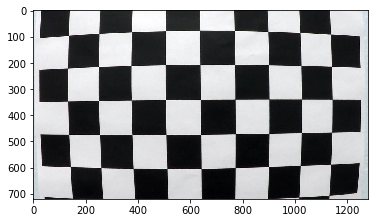

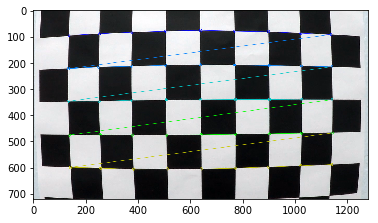

In [28]:
# Find corner

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 5#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = 'calibration1.jpg'
img = cv2.imread(fname)

plt.imshow(img)
plt.show()

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.show()
else:
    print("could not find corners")
    


def draw_and_display_corners(img,corner,nx,ny):
    cv2.drawChessboardCorners(img, (nx, ny), corners, True)
    plt.imshow(img)
    plt.show()

# Functions

In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob

####################  Preparation functions ###############################

def find_chessbox_corner(img,nx,ny):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.findChessboardCorners(gray, (nx, ny), None)


def camera_calibration(images):
    objpoints = []
    imgpoints = []
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    for fname in images:
        # read images
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = find_chessbox_corner(img,9,6)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            print(fname)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist


#################### pipeline functions #####################################

def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def perspective_img_warp(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    
def thresholding_gray_2_bin(gray_img, thresh = (0,255)):
    binary = np.zeros_like(gray_img)
    binary[(gray_img >= thresh[0]) & (gray_img <= thresh[1])] = 1
    return binary

def abs_sobel_thresh(gray, orient='x', sobel_kernel = 3, thresh = (0,255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Return the result
    return thresholding_gray_2_bin(scaled_sobel, thresh = thresh)

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Return the binary image
    return thresholding_gray_2_bin(gradmag, thresh = mag_thresh)

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Return the binary image
    return thresholding_gray_2_bin(absgraddir, thresh = thresh)

### color thresholding
def Rgb_Thresholding(image, channel = 'r', threshold = (0,255)):
    binary = np.zeros_like(R)
    if channel == 'r':
        binary[(image[:,:,0] > threshold[0]) & (image[:,:,0] <= threshold[1])] = 1
    elif channel == 'g':
        binary[(image[:,:,1] > threshold[0]) & (image[:,:,1] <= threshold[1])] = 1
    elif channel == 'b':
        binary[(image[:,:,2] > threshold[0]) & (image[:,:,2] <= threshold[1])] = 1
    return binary

def hls_thresholding(img, channel = 0, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,channel]
    binary_output = np.zeros_like(s_channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

def combine_2_binary_images(img1,img2):
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
def color_Gradient_Threshold(img, thresholds = []):
    ######## gradient threshold
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresholds[0])
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresholds[1])
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=thresholds[2])
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=thresholds[3])
    # combine gradient
    grad_combined = np.zeros_like(dir_binary)
    grad_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    ######### color thresholding
    # red thresholding
    rgb_thresh = Rgb_Thresholding(img, channel = 'r', threshold = thresholds[4])
    # S chanel thresholding
    s_thresh = hls_thresholding(img, channel = 2, thresh = hls_thresh)
    # combine gradient and color threshold
    combined_threshold = combine_2_binary_images(grad_combined, thresholds[5])
    
    return combined_threshold

def find_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def calculate_curvature(curve, locations = 0):
    return ((1 + (2*curve[0]*locations + curve[1])**2)**1.5) / np.absolute(2*curve[0])

def Pineline(img, M, mtx, dist, thresholds = []):
    # Distortion correction of the input image
    undistorted_img = undistort_img(img, mtx, dist)
    # color and gradient threshold
    thesholded_image = color_Gradient_Threshold(undistorted_img, thesholds = thresholds)
    # Perspective transform
    warped_img = perspective_img_warp(thesholded_image, M)
    # finding lines
    left_fit, right_fit = find_lines(warped_img)
    # calculate curvature
    left_curverad = calculate_curvature(left_fit)
    right_curverad = calculate_curvature(right_fit)
    
    
def Plot_Images(images, number_img_per_row, title = None):
    """
        This function plot an arbitrary number of images
            input: 
                images: a numpy array of images
                title: a title for the plot
    """
    image_number = len(images)
    fig, axs = plt.subplots(int(image_number / number_img_per_row),number_img_per_row, 
                            figsize=(16, 4 * image_number/number_img_per_row))
    fig.suptitle(title, fontsize=18)
    axs = axs.ravel()    
    for n in range(image_number):
        axs[n].axis('off')
        if images[n].shape[2] == 1:
            axs[n].imshow(images[n].squeeze(), cmap='gray')
        else:
            axs[n].imshow(images[n])
    plt.show() 

# Camera calibration

In [18]:
images = glob.glob('./camera_cal/calibration*.jpg')

mtx, dist = camera_calibration(images)

print(mtx, dist)

./camera_cal\calibration1.jpg
./camera_cal\calibration4.jpg
./camera_cal\calibration5.jpg
[[1.15662906e+03 0.00000000e+00 6.69041438e+02]
 [0.00000000e+00 1.15169194e+03 3.88137239e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.23157149 -0.1200054  -0.00118338  0.00023305  0.15641575]]


# Perspective transform

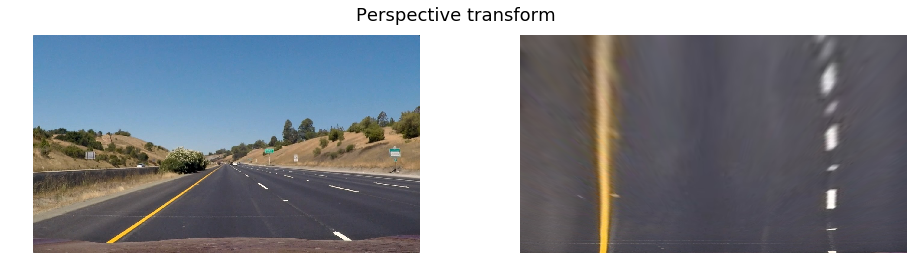

In [45]:
# read 1 test image
image = 'straight_lines1.jpg'
img = mpimg.imread(image)

src = np.float32([
    [271,672],
    [603,445],
    [678,445],
    [1035,672]])
dst = np.float32([
    [271,720],
    [271,0],
    [1035,0],
    [1035,720]])

M = cv2.getPerspectiveTransform(src, dst)

warped = perspective_img_warp(img, M)

Plot_Images([img, warped],2, title = 'Perspective transform')

# Thresholds

In [ ]:
thresholds = []
thresholds[0] = (20,100)  # gradx
thresholds[1] = (20,100)  # grady
thresholds[2] = (30,100)  # magnitude gradient
thresholds[3] = (0.7,1.2) # direction gradient
thresholds[4] = (200, 255) # red color threshold
thresholds[5] = (90, 255) # s channel in HLS color threshold

# Pipeline